In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mudata as mu 
import scanpy as sc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import defaultdict
import json


In [3]:
import sys 
sys.path.append('../src')
from spaceoracle import SpaceOracle

### Load data & choose experiment

In [4]:
from utils import h5mu_to_h5ad

mdata = mu.read_h5mu('../data/kidney/mdata_3.h5mu')
adata = h5mu_to_h5ad(mdata)


In [5]:
chips = np.unique(adata.obs['chip'])
chips

array(['275', '276', '281', '285', '286', '319', '405', '408', '409',
       '410', '413'], dtype=object)

In [6]:
from utils import process_adata

experiment = '275'
adata = adata[adata.obs['chip'] == experiment]

adata = process_adata(adata, n_top_genes=3000, mouse=True)
adata

AnnData object with n_obs × n_vars = 7166 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'npc-l1p', 'raw_count'
    obsp: 'connectivities', 'distances'

In [7]:
ct_counts = adata.obs['ct2'].value_counts()
ct_counts

ct2
Mac                             5196
DC                               355
T                                336
B                                303
Granulocyte                      253
Endothelial_DVR                  155
Endothelial_Anti-Apoptosis       154
Endothelial_Capilary             106
Epithelial_Collecting_Duct       101
Epithelial_Henle_Loop             66
Mono                              50
Pericyte                          26
Epithelial_Nephron                17
NK                                14
RBC                               11
Endothelial_Mmrn1+                 6
Epithelial_Pelvis                  5
VSMC                               4
Fibroblast                         3
Epithelial_Transitional            3
Neuronal_Schwann_Cell              1
Epithelial_Convoluted_Tubule       1
Name: count, dtype: int64

In [8]:
from utils import filter_clusters

low_count_clusters = [ct for ct, count in zip(ct_counts.index, ct_counts) if count < 100]
adata = filter_clusters(adata, c=low_count_clusters, annot = 'ct2')
adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'npc-l1p', 'raw_count'
    obsp: 'connectivities', 'distances'

In [9]:
X = adata.obsm['spatial'][:, 0]
Y = adata.obsm['spatial'][:, 1]
Z = []

occurrence = defaultdict(int)
for x, y in zip(X, Y):
    height = occurrence[(x,y)]
    occurrence[(x,y)] += 1
    Z.append(height)


In [10]:
ncells = X.shape[0]

fig = px.scatter_3d(
    x=X, y=Y, z=Z,
    color=adata.obs['ct2'],
    )

fig.update_traces(
    marker=dict(size=2), 
    line=dict(width=2, color='black')
    )

fig.show()


In [80]:
cell_type_mapping = {cluster: i for i, cluster in enumerate(np.unique(adata.obs['ct2']))}
adata.obs['cluster'] = [cell_type_mapping[cluster] for cluster in adata.obs['ct2']]
adata.obs['cluster'] = adata.obs['cluster'].astype('category')

reverse = {i : cluster for cluster, i in cell_type_mapping.items()}
with open('../data/kidney/celltype_assign.json', 'w') as f:
    json.dump(reverse, f, indent=4)

### Get CO GRN

In [11]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 180

2024-10-02 20:55:54.451776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 20:55:54.716221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 20:55:54.755465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 20:55:55.215990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the a

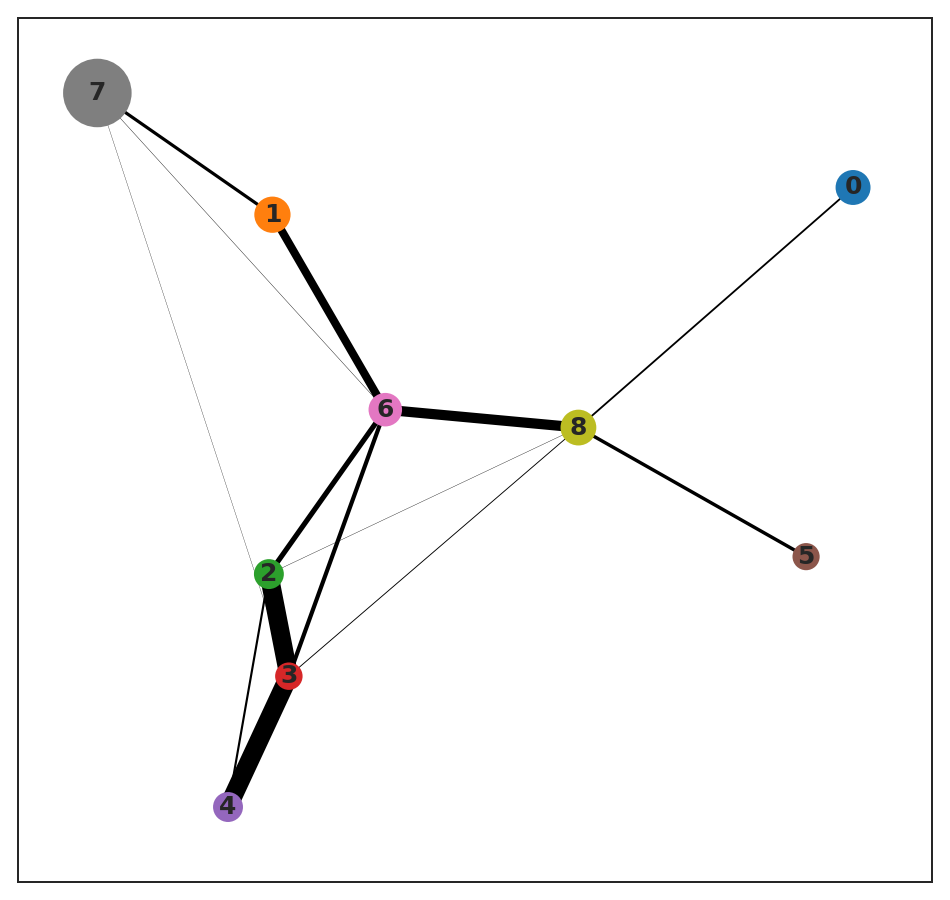

CPU times: user 24.1 s, sys: 9.01 s, total: 33.1 s
Wall time: 36.4 s


In [14]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')
sc.tl.paga(adata, groups='cluster')
plt.rcParams["figure.figsize"] = [6, 6]
sc.pl.paga(adata)

In [15]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

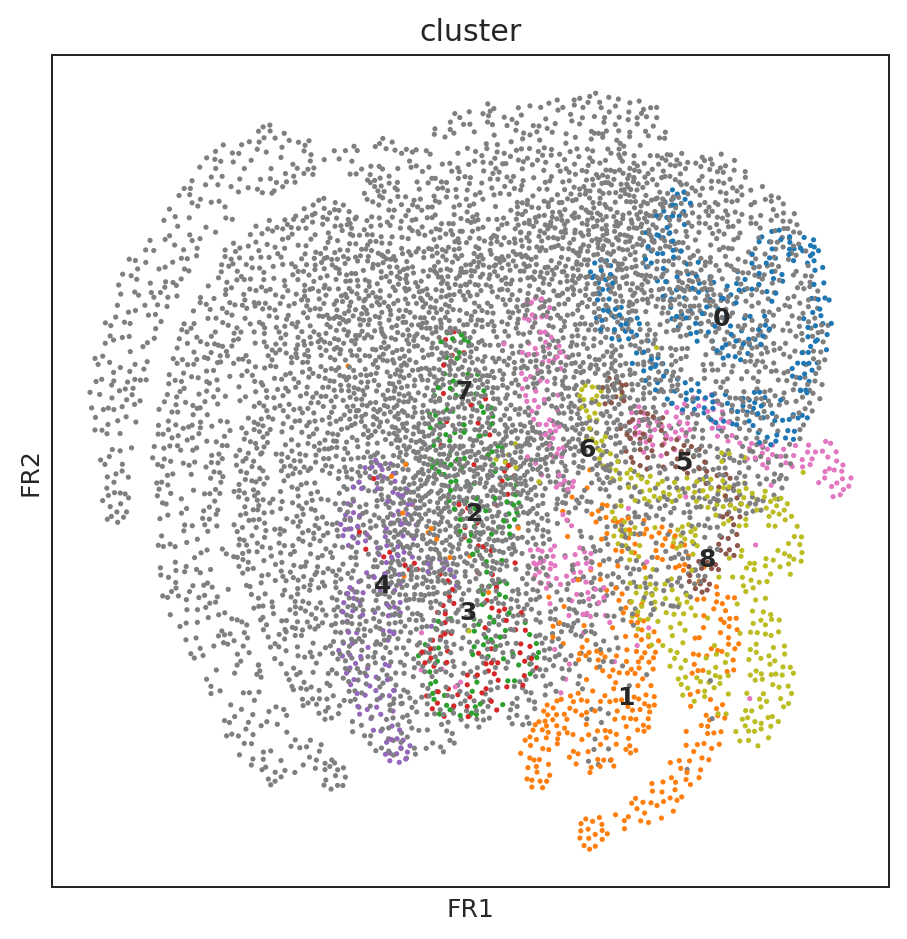

In [16]:
sc.pl.draw_graph(adata, color='cluster', legend_loc='on data')

In [17]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cluster",
    embedding_name="X_draw_graph_fr"
)

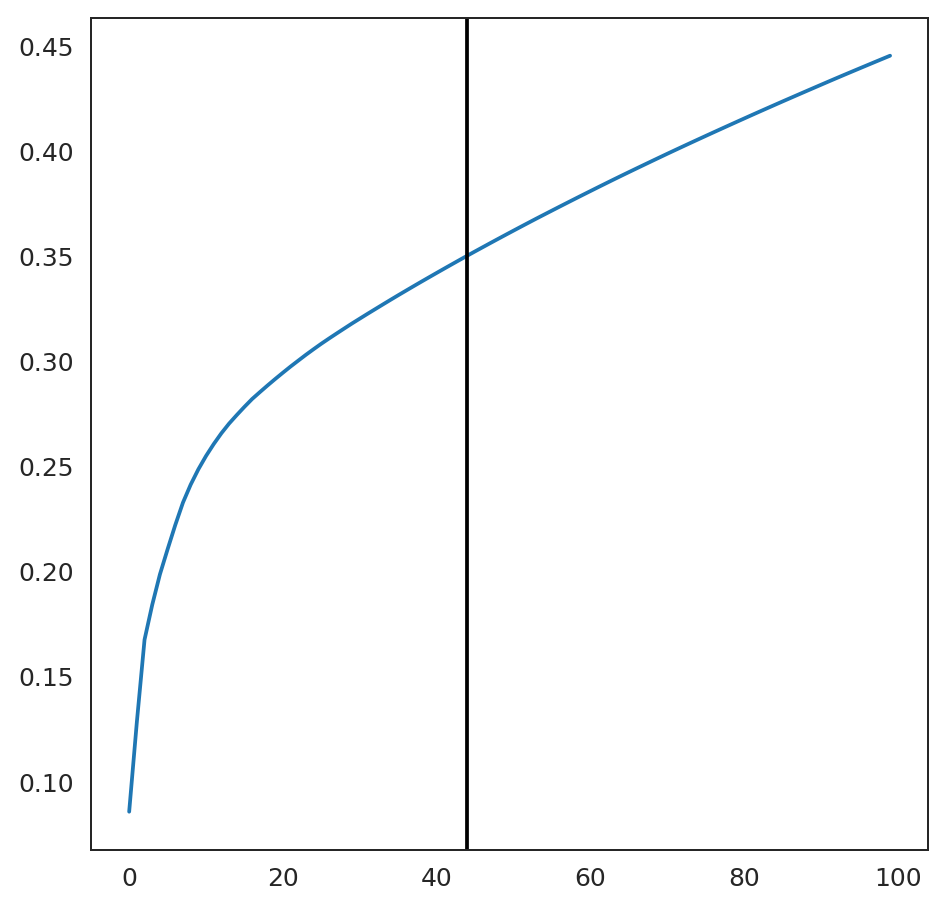

44


In [18]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [19]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

cell number is :6959
Auto-selected k is :173


In [20]:
oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

In [20]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [21]:
adata.obsm['X_pca'].shape

(6959, 50)

In [22]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cluster", 
    alpha=10,
    verbose_level=10, 
    # test_mode=True,
    # n_jobs=8
)

  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 7...


  0%|          | 0/2295 [00:00<?, ?it/s]

Inferring GRN for 8...


  0%|          | 0/2295 [00:00<?, ?it/s]

CPU times: user 25min 26s, sys: 6.41 s, total: 25min 33s
Wall time: 25min 58s


In [23]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
import pickle

with open('../data/kidney/celloracle_links.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)


In [25]:
with open('../data/kidney/celloracle_coefs.pkl', 'wb') as f:
    pickle.dump(oracle.coef_matrix_per_cluster, f)

### Train BayesPix

In [106]:
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.models.estimators import device
from spaceoracle.models.probabilistic_estimators import ProbabilisticPixelAttention

In [108]:
np.max(adata.obsm['spatial']) - np.min(adata.obsm['spatial'])

35

In [109]:
spatial_dim = 35

spaceoracle.SpaceOracle.imbue_adata_with_space(
    adata=adata, annot='cluster', 
    spatial_dim=spatial_dim, in_place=True, 
    method='fast'
)

🌍️ Generating spatial 35x35 maps...


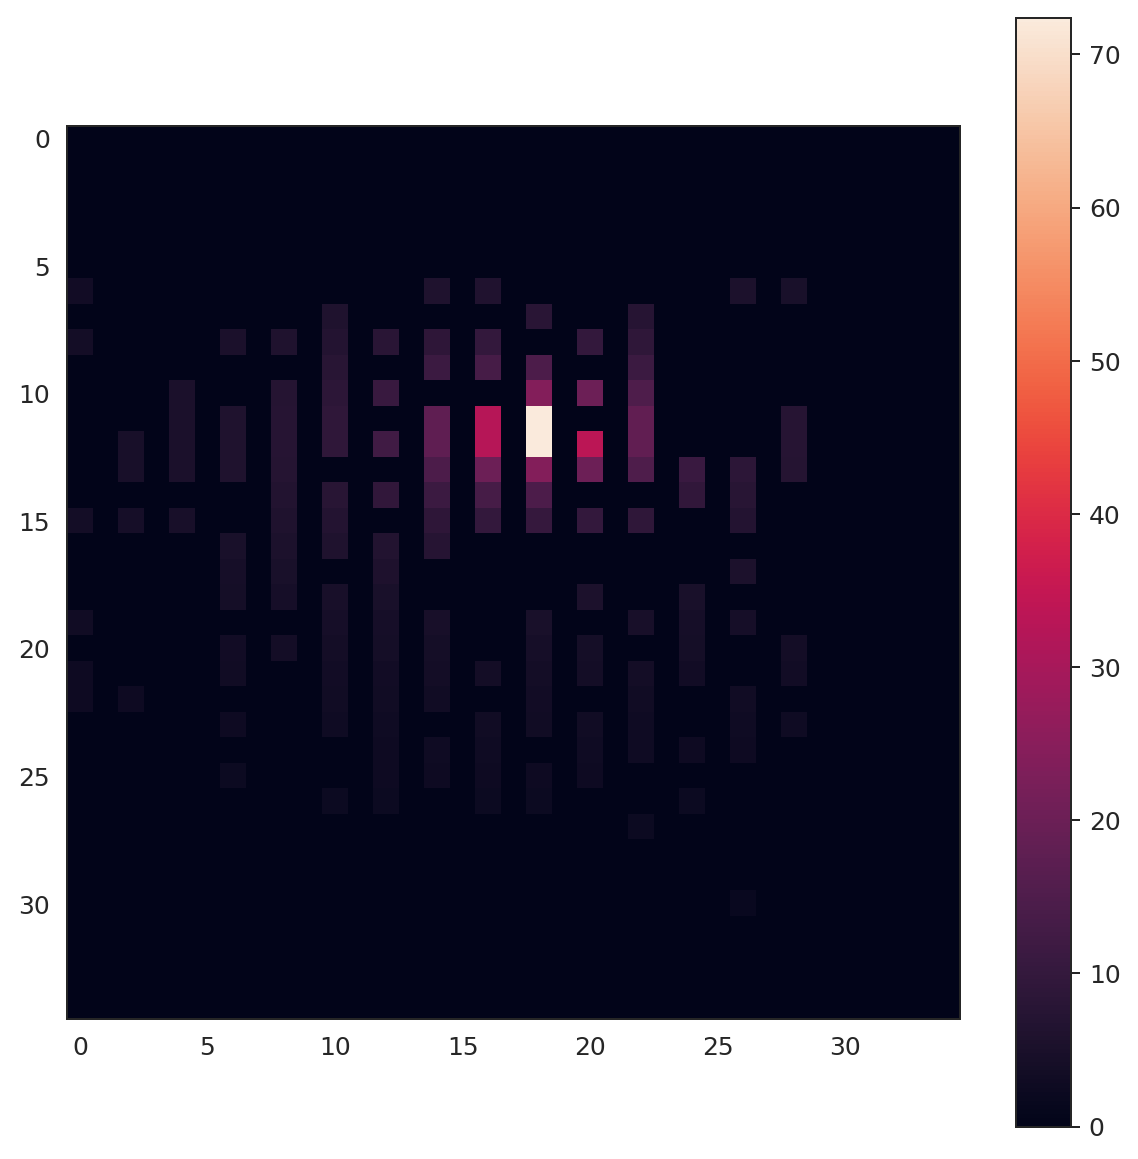

In [110]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.imshow(adata.obsm['spatial_maps'][1][0])
plt.colorbar()
plt.show()

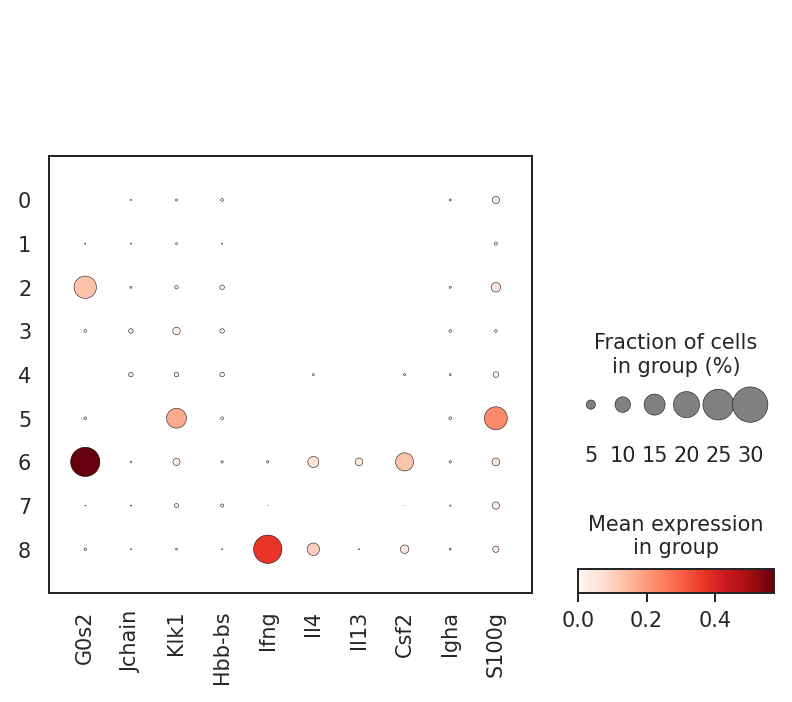

In [111]:
# adata.obs['cluster'] = adata.obs['cluster'].astype(int)

sc.pp.highly_variable_genes(adata, n_top_genes=10)
marker_genes = adata.var_names[adata.var['highly_variable']]

sc.pl.dotplot(adata, marker_genes, groupby='cluster')

In [143]:
target_gene = 'Cd74'

from utils import get_imputed

adata = get_imputed(adata, spatial_dim, annot='cluster')
adata

🌍️ Generating spatial 35x35 maps...


AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'batch', 'rxn', 'n_counts', '%mito_ms', 'leiden', 'leiden_R', 'ct1', 'ct2', 'ct3', 'high_q', 'ct4', 'chip', 'exp', 'cond', 'samp-id', 'samp-type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cluster', 'Tbx21_beta', 'Tbx21_beta_'
    var: 'n_counts', 'n_cells', 'mean', 'std', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dimred_params', 'leiden', 'log1p', 'neighbors', 'pca', 'plt', 'rank_genes_groups', 'umap', 'hvg', 'diffmap_evals', 'paga', 'cluster_sizes', 'cluster_colors', 'draw_graph', 'dendrogram_cluster'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmo

In [144]:
from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork
co_grn = MouseKidneyRegulatoryNetwork()

In [145]:
%%time
import pyro
pyro.clear_param_store()

estimator = ProbabilisticPixelAttention(
    adata, target_gene=target_gene, co_grn=co_grn, layer='imputed_count', annot='cluster')

estimator.fit(
    annot='cluster', 
    max_epochs=10, 
    learning_rate=7e-4, 
    spatial_dim=spatial_dim,
    batch_size=512,
    alpha=0.1,
    cache=False
)

Fitting 9 models in parallel... with 9/64 cores


CPU times: user 1min 22s, sys: 502 ms, total: 1min 22s
Wall time: 1min 51s


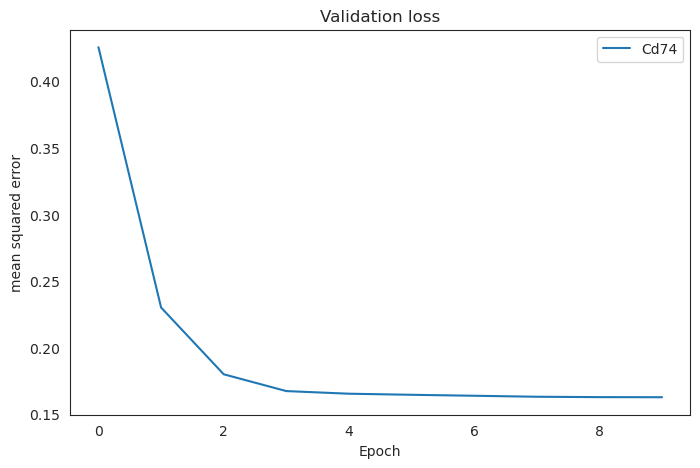

In [146]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses, label=target_gene)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title(f'Validation loss')
plt.legend()
plt.show()

In [147]:
import torch
adata_train = adata

In [148]:
est = estimator
with torch.no_grad():
    betas_ = est.get_betas(
        spatial_maps=np.array(adata_train.obsm['spatial_maps']),
        labels=np.array(adata_train.obs['cluster']),
    )

    y_pred = est.predict_y(
        est.model, 
        torch.from_numpy(betas_).to(device), 
        torch.from_numpy(np.array(adata_train.obs['cluster'])).to(device),
        torch.from_numpy(
            adata_train.to_df(layer=est.layer)
            [est.regulators].values.astype(np.float32)).to(device)).cpu().numpy()

In [149]:
anchors = np.stack(
    [est.beta_dists[label].mean(0) for label in torch.from_numpy(
        np.array(adata_train.obs['cluster'])).to(device).cpu().numpy()], 
    axis=0
)
betas = betas_*anchors

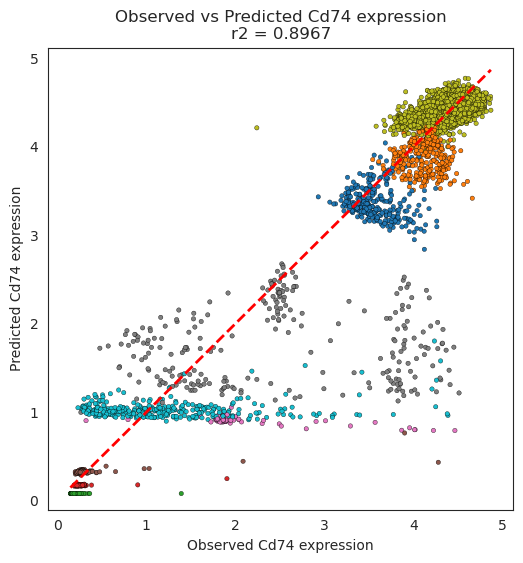

In [150]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100

y = adata_train.to_df(layer=est.layer)[[target_gene]]

sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_train.obs.cluster.values[:], 
    cmap='tab10', 
    edgecolor='black', linewidth=0.25)

plt.xlabel(f'Observed {target_gene} expression')
plt.ylabel(f'Predicted {target_gene} expression')
plt.title(f'Observed vs Predicted {target_gene} expression\n'
    f'r2 = {r2_score(y.values.reshape(-1), y_pred.reshape(-1)):.4f}')
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
# Add x=y line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.show()

In [151]:
estimator.grn.get_regulators(adata, target_gene)

['Ahr',
 'Atf3',
 'Bcl11a',
 'Bcl11b',
 'Bhlhe40',
 'Cebpb',
 'E2f2',
 'E2f3',
 'Ebf1',
 'Egr1',
 'Egr2',
 'Elk4',
 'Ets1',
 'Foxi1',
 'Hivep3',
 'Hsf1',
 'Irf4',
 'Klf12',
 'Klf2',
 'Klf5',
 'Klf6',
 'Klf8',
 'Maff',
 'Mafk',
 'Myc',
 'Nfkb2',
 'Nr3c1',
 'Pax5',
 'Pitx2',
 'Plagl1',
 'Polr2a',
 'Rara',
 'Rel',
 'Snai1',
 'Stat3',
 'Wt1',
 'Zeb1']

In [155]:
tf = 'Myc'
adata_train.obs[f'{tf}_beta'] = betas[:, est.regulators.index(tf)+1]
adata_train.obs[f'{tf}_beta_'] = [anchors[adata_train.obs['cluster'] == x][:, est.regulators.index(tf)+1].mean() for x in adata_train.obs['cluster'].values]

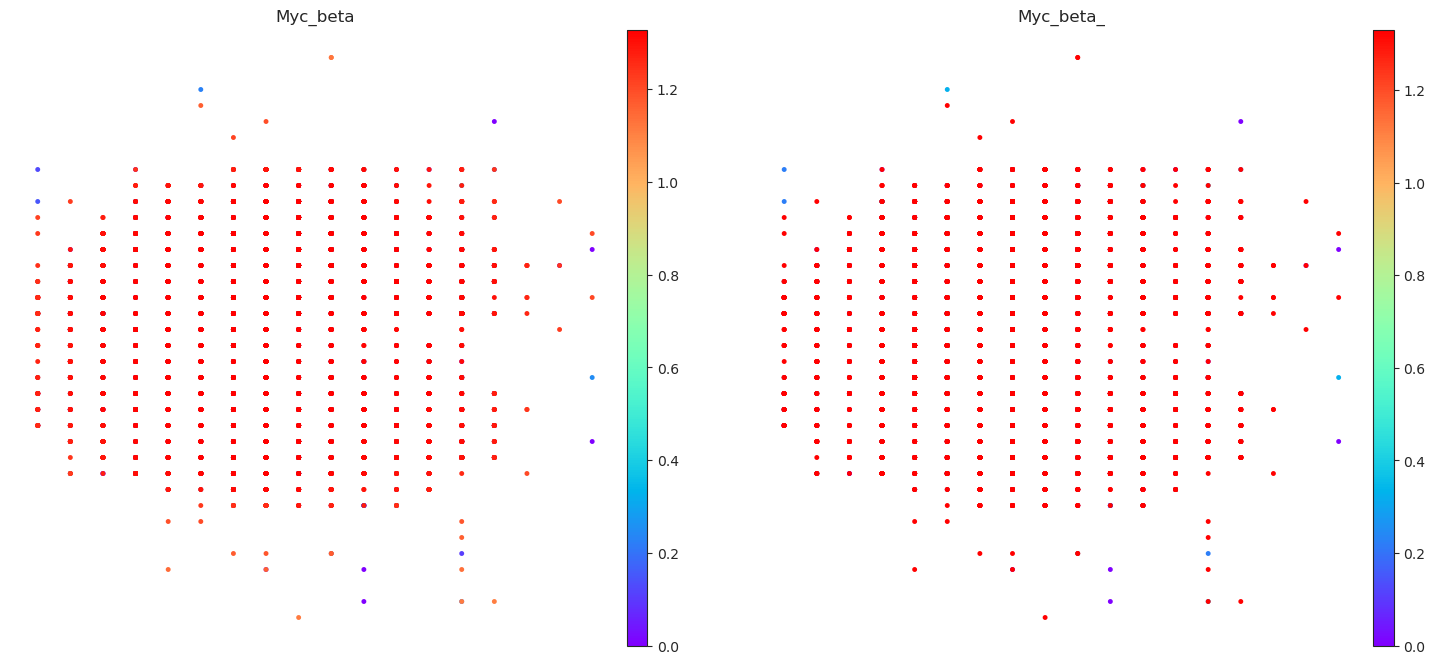

In [159]:
plt.rcParams['figure.figsize'] = [8, 8]
sc.pl.embedding(
    adata_train, 
    color=[f'{tf}_beta', f'{tf}_beta_'], 
    basis='spatial', 
    layer='imputed_count', 
    cmap='rainbow',
    frameon=False,
    show=True,
    s=50, linewidth=0, edgecolor='black'
)

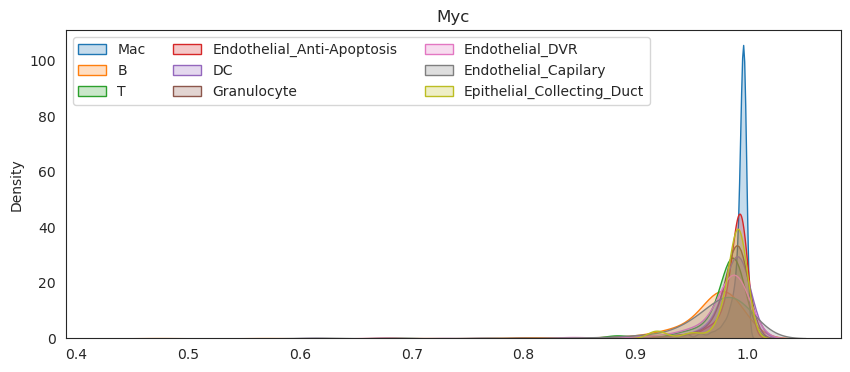

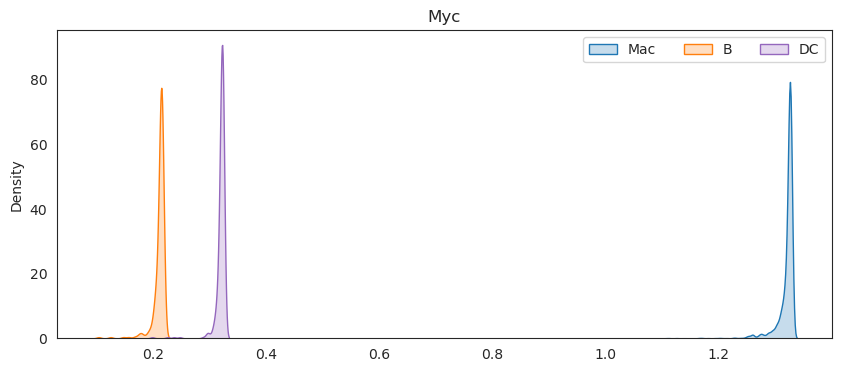

In [161]:
plt.rcParams['figure.figsize'] = [10, 4]
df = pd.DataFrame(betas_, columns=['intercept']+est.regulators)

for celltype in adata_train.obs['ct2'].unique():
    sns.kdeplot(
        df[tf].values[adata_train.obs['ct2'] == celltype], 
        shade=True, label=celltype)
plt.title(tf)
plt.legend(ncols=3)
plt.show()

df = pd.DataFrame(betas, columns=['intercept']+est.regulators)
for celltype in adata_train.obs['ct2'].unique():
    sns.kdeplot(
        df[tf].values[adata_train.obs['ct2'] == celltype], 
        shade=True, label=celltype)
plt.title(tf)
plt.legend(ncols=3)
plt.show()

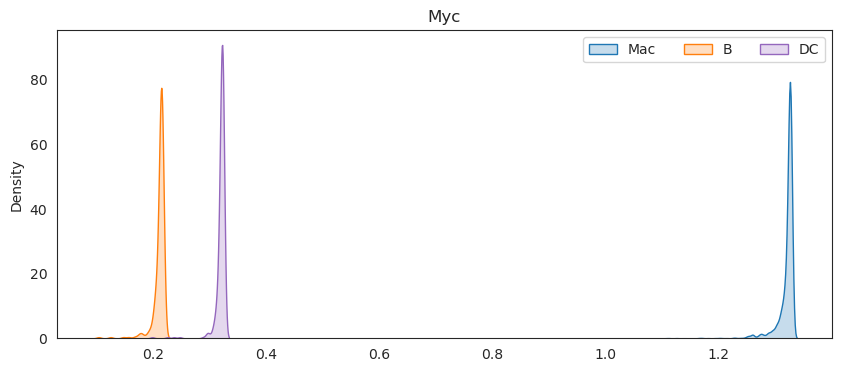

In [162]:
df = pd.DataFrame(betas, columns=['intercept']+est.regulators)
for celltype in adata_train.obs['ct2'].unique():
    sns.kdeplot(
        df[tf].values[adata_train.obs['ct2'] == celltype], 
        shade=True, label=celltype)
plt.title(tf)
plt.legend(ncols=3)
plt.show()